In [ ]:
pip install numpy==1.26.4

In [1]:
pip install captum

In [2]:
pip install lime

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=949b88556d7d5ffe0e980f674c071e858aa27a81a16f5a4a1f3c58f4e33bf20a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# ============================================
# Explainability sederhana: ResNet34 + Grad-CAM + LIME
# ============================================
# 1) Import library
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.models import ResNet34_Weights
from PIL import Image
import matplotlib.pyplot as plt


# --------- Konfigurasi sederhana ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# IMAGE_PATH = "/content/sample_data/basketball2.jpg"  # TODO: ganti dengan path gambar
TOPK = 5                       # tampilkan top-5 prediksi

# 2) Load model + preprocessing + label ImageNet
weights = ResNet34_Weights.DEFAULT
model = models.resnet34(weights=weights).to(DEVICE).eval()
preprocess = weights.transforms()  # Resize+CenterCrop+ToTensor+Normalize
IMAGENET_CLASSES = weights.meta["categories"]

# Util: muat gambar & siapkan 0-1 numpy untuk visualisasi
def load_image_for_model(path: str):
    pil = Image.open(path).convert("RGB")
    x = preprocess(pil).unsqueeze(0)  # (1,3,H,W) normalized
    return pil, x

def to_numpy01(pil_img: Image.Image):
    arr = np.asarray(pil_img).astype(np.float32) / 255.0  # (H,W,3) float [0..1]
    return arr

# 3) Prediksi gambar + tampilkan top-k
@torch.no_grad()
def predict_image(x: torch.Tensor):
    logits = model(x.to(DEVICE))
    probs = logits.softmax(dim=1).squeeze(0).cpu().numpy()
    topk_idx = np.argsort(probs)[::-1][:TOPK]
    topk = [(IMAGENET_CLASSES[i], float(probs[i])) for i in topk_idx]
    return topk, probs, topk_idx

def show_topk(pil, topk):
    plt.figure(figsize=(6,4))
    plt.imshow(pil); plt.axis("off")
    title = "Top-{} Prediksi:\n".format(len(topk)) + "\n".join([f"{i+1}. {lbl} ({p:.3f})" for i,(lbl,p) in enumerate(topk)])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 4) Grad-CAM (sederhana) pada layer konvolusi terakhir ResNet34
class GradCAM:
    def __init__(self, model, target_layer_name="layer4"):
        self.model = model
        self.model.eval()
        # Ambil layer target (di ResNet34: layer4 adalah conv block terakhir)
        self.target_layer = dict([*model.named_modules()])[target_layer_name]

        self.activations = None
        self.gradients = None

        # hook untuk simpan aktivasi & grad
        def fwd_hook(module, inp, out):
            self.activations = out.detach()               # (B, C, H, W)
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()         # (B, C, H, W)

        self.fwd_handle = self.target_layer.register_forward_hook(fwd_hook)
        self.bwd_handle = self.target_layer.register_full_backward_hook(bwd_hook)

    def __call__(self, x, class_idx=None):
        x = x.to(DEVICE)
        logits = self.model(x)                            # forward -> isi self.activations
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
        # backward pada indeks kelas target
        self.model.zero_grad(set_to_none=True)
        loss = logits[:, class_idx].sum()
        loss.backward()                                   # -> isi self.gradients

        # weights: GAP pada gradient spatial
        grads = self.gradients[0]                         # (C, H, W)
        acts  = self.activations[0]                       # (C, H, W)
        weights = grads.mean(dim=(1,2))                   # (C,)a

        # CAM: ReLU( sum_c (w_c * A_c) )
        cam = torch.zeros(acts.shape[1:], device=acts.device)  # (H, W)
        for c, w in enumerate(weights):
            cam += w * acts[c]
        cam = torch.relu(cam)

        # normalisasi -> [0,1], resize ke ukuran gambar input (setelah preprocess crop)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam_np = cam.detach().cpu().numpy()
        return cam_np, class_idx

    def close(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

def overlay_cam(rgb01: np.ndarray, cam01: np.ndarray, alpha=0.35):
    # rgb01: (H,W,3) [0..1], cam01: (h,w) [0..1] -> resize cam ke rgb size
    from skimage.transform import resize
    H, W = rgb01.shape[:2]
    cam_resized = resize(cam01, (H, W), preserve_range=True, anti_aliasing=True)
    # buat heatmap sederhana dengan matplotlib colormap
    cmap = plt.get_cmap("jet")
    heat = cmap(cam_resized)[...,:3]  # (H,W,3) [0..1]
    overlay = (1 - alpha) * rgb01 + alpha * heat
    overlay = np.clip(overlay, 0, 1)
    return heat, overlay

In [3]:
def tampilkan_hasil(image_path):
  # --- load image ---
  pil, x = load_image_for_model(image_path)

  # --- prediksi & tampilkan top-k ---
  topk, probs, topk_idx = predict_image(x)
  show_topk(pil, topk)
  pred_idx = int(topk_idx[0])  # kelas teratas

  # --- Grad-CAM ---
  gradcam = GradCAM(model, target_layer_name="layer4")
  cam01, cls_idx = gradcam(x, class_idx=pred_idx)
  gradcam.close()

  # visualisasi Grad-CAM
  rgb01 = to_numpy01(pil)
  heat, overlay = overlay_cam(rgb01, cam01, alpha=0.35)

  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1); plt.imshow(pil); plt.axis("off"); plt.title("Original")
  plt.subplot(1,3,2); plt.imshow(heat); plt.axis("off"); plt.title("Grad-CAM Heatmap")
  plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off"); plt.title(f"Grad-CAM Overlay ({IMAGENET_CLASSES[pred_idx]})")
  plt.tight_layout(); plt.show()

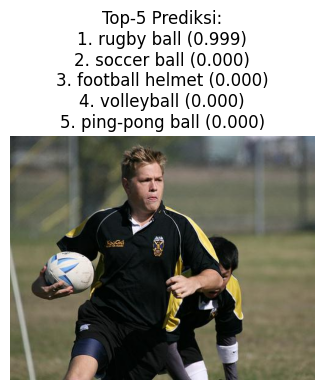

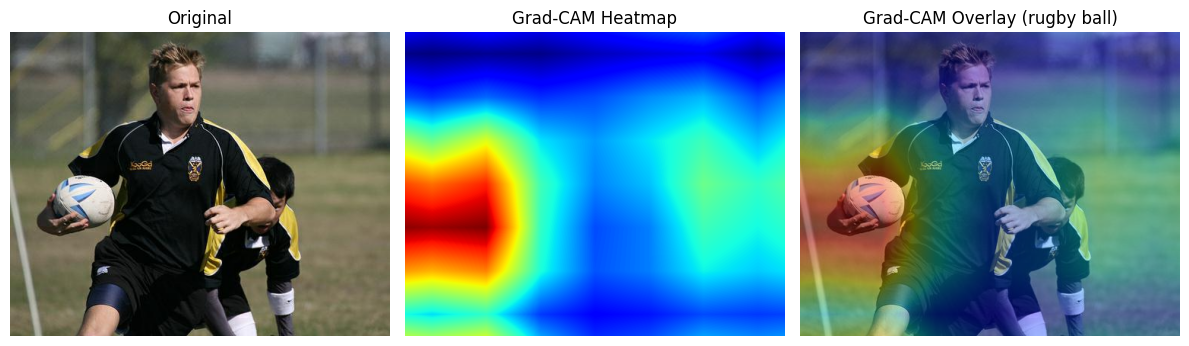

In [4]:
tampilkan_hasil(r"rugbyball\ball.jpg")